# Quantum Chemistry Tutorial 4 - Geometry optimization and dispersion correction

1. **S. G. Nana Engo**, serge.nana-engo@facsciences-uy1.cm
    * Department of Physics, Faculty of Science, University of Yaounde I
2. **J-P. Tchapet Njafa**, jean-pierre.tchapet-njafa@univ-maroua.cm
    * Department of Physics, Faculty of Science, University of Maroua
       
March 2024

Dans ce tutoriel, nous allons apprendre à optimiser la structure géométrique des molécules en utilisant 
* RDKit
* xTB et CREST
* GeometriC de PySCF

Par la suite, nous allons inclure la correction de dispersion en utilisant dftd4.

Il est à noter que le framework xTB permet de
* permettre un accès de bas niveau aux composants formant l'expression énergétique réelle;
* fournir un cadre pour gérer et manipuler les données de paramétrage;
* fournir des fonctionnalités au-delà des calculs à point unique (single-point) dans cette bibliothèque : l'optimisation géométrique et  la dynamique moléculaire.

## Choix des coordonnées

Un concept fondamental en chimie quantique est la surface d’énergie potentielle (PES, potential energy surface) multidimensionnelle. Il capture l'interaction entre les degrés de liberté électroniques et nucléaires dans un système, et les points stationnaires sur le PES sont importants pour élucider les conformations moléculaires et expliquer les mécanismes des réactions chimiques et photochimiques. Les dérivées du premier (**gradient**) et du second ordre (**hessienne**) de l'énergie par rapport aux déplacements nucléaires sont des éléments clés pour localiser ces points (minima et états de transition (transition states, TS)) et déterminer les voies de réaction d'énergie minimale.

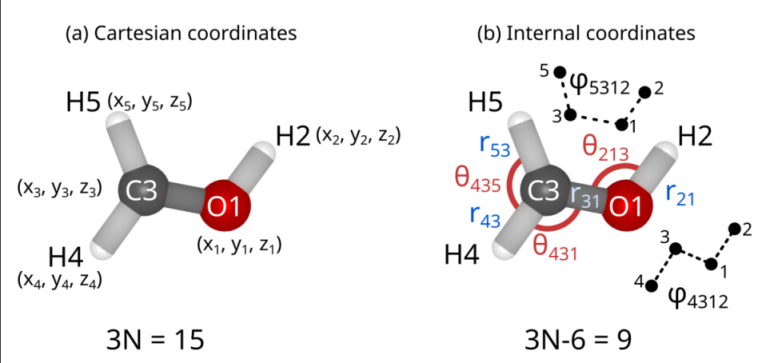

Examinons le choix des coordonnées dans lesquelles ces dérivées énergétiques sont exprimées.

### Coordonnées cartésiennes

La manière la plus simple de définir les positions atomiques consiste à utiliser un système de référence cartésien et à définir chaque position atomique en termes de sa position, (x,y,z)-coordonnées. Dans ce système de coordonnées, il est très facile de déterminer l'énergie totale et le gradient d'énergie, mais ce choix n'est pas favorable à l'optimisation géométrique, car ces coordonnées sont fortement couplées entre elles.

### Coordonnées internes

Un choix plus avantageux consiste à travailler avec des coordonnées internes, telles que les longueurs de liaison, les angles de valence et les dièdres. L'ensemble de coordonnées internes le plus connu est la **matrice Z**, qui utilise ces propriétés pour décrire la structure moléculaire. Cependant, l'utilisation de coordonnées internes pose deux défis : 
1. le choix des coordonnées n'est pas unique et
2. les coordonnées internes doivent être reconverties en coordonnées cartésiennes pour calculer l'énergie et le gradient. 


## Théorie de l'état de transition

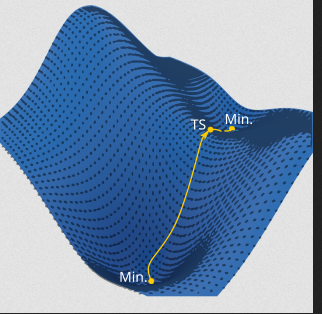

La deuxième classe de points particuliers sur les PES dont nous discutons ici sont les états de transition. Ceux-ci sont importants pour expliquer les mécanismes des réactions chimiques et photochimiques. Les états de transition sont des points selles (**saddle points**) de premier ordre sur la surface d'énergie potentielle **et sont caractérisés par un gradient nul combiné à un Hessien qui a une et une seule valeur propre négative**. Les optimisations d'état de transition utilisent donc des approches quadratiques, telles que les méthodes de Newton-Raphson et quasi-Newton. L’idée derrière une optimisation d’état de transition est de faire un pas de Newton-Raphson dans la direction opposée au gradient pour chaque valeur propre positive de la Hesse et un pas de Newton-Raphson le long du gradient pour la valeur propre négative de la Hesse. Cela signifie que dans une coordonnée, l’énergie est maximisée, tandis que dans toutes les autres coordonnées, elle est minimisée. **Cela signifie également que la géométrie initiale doit être similaire à l’état de transition et contenir une valeur négative du Hessian**. La pratique courante consiste donc à effectuer une optimisation contrainte, par exemple en effectuant un balayage détendu des coordonnées d'une coordonnée impliquée dans la réaction. La structure d’énergie la plus élevée peut alors être considérée comme une géométrie initiale raisonnable pour une recherche d’état de transition.

## Optimisation orbitale 

L'optimisation orbitale, souvent simplement appelée optimisation géométrique, optimisation moléculaire ou relaxation, est le processus par lequel la géométrie d'une molécule est ajustée pour trouver une structure avec l'énergie la plus basse possible. Cette structure optimisée correspond typiquement à une configuration stable, soit un **minimum local** (une espèce stable), soit un **état de transition** (une configuration à haute énergie entre deux espèces stables).

En termes pratiques, les ingrédients pour effectuer une optimisation géométrique comprennent : 
1. les coordonnées moléculaires initiales,
2. un choix de système de coordonnées,
3. l'énergie à une géométrie spécifique $E(\mathbf{x})$,
4. le gradient $\mathbf{g}(\mathbf{x})=\nabla E(\mathbf{x})$,
5. le Hessian, et
6. une procédure pour mettre à jour les coordonnées et le Hessian et se déplacer sur la surface d’énergie potentielle vers une énergie plus faible.

Les étapes d'une optimisation de la géométrie moléculaire sont illustrées dans la figure ci-dessous.

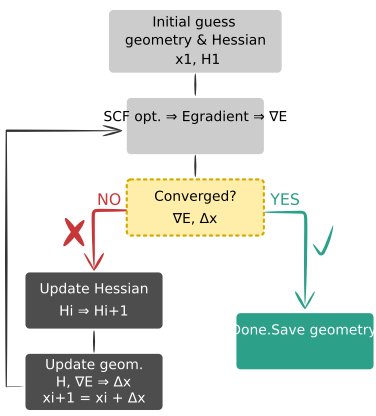s

 L'optimisation orbitale dans les méthodes de structure électronique offre les avantages suivants : 
 1. Les énergies deviennent variationnelles en ce qui concerne les rotations orbitales, il n'y a donc pas besoin de réponse orbitale lors du calcul des gradients nucléaires; 
 2. Les propriétés peuvent être calculées plus facilement car il n'y a aucune contribution de réponse orbitale aux matrices de densité; 
 3. Les pôles parasites dans les fonctions de réponse pour des méthodes inexactes telles que la théorie des grappes couplées (coupled cluster ou CC) peuvent être supprimées; 
 4. Les problèmes de rupture de symétrie peuvent être mieux décrits.

### Comment ça marche ?

1. **Entrée de géométrie initiale** : l'utilisateur fournit une première estimation de la géométrie moléculaire. Cela peut être basé sur des données expérimentales, une intuition chimique ou des résultats de calculs antérieurs, des applications comme RDKit ou Openbabel.

2. **Choix de la méthode** : Une méthode de théorique quantique (par exemple, méthodes Hartree-Fock, DFT, post-Hartree-Fock) et un ensemble de bases sont choisis en fonction du système et de la précision souhaitée.

3. **Processus itératif** : le programme de structure électronique ajuste de manière itérative les positions des atomes pour réduire l'énergie totale. Ceci est réalisé en calculant les forces exercées sur les atomes et en les utilisant pour prédire une nouvelle géométrie à plus faible énergie.

4. **Convergence** : le processus se poursuit jusqu'à ce que des changements dans la géométrie produisent des changements d'énergie négligeables (critère de convergence satisfait), indiquant qu'une structure optimisée a été trouvée.

Il est important de souligner qu'alors que l’objectif est de trouver le minimum global (la structure énergétique la plus basse absolue), en pratique, l’optimisation géométrique trouve souvent des minima locaux. Des techniques supplémentaires peuvent être nécessaires pour garantir que le minimum global a été localisé.

### DFT flowchart

![DFT_Flowchart.jpg](Graphics/DFT_Flowchart.jpg)

Lorsque la molécule est loin de la géométrie d'équilibre, ce serait un gaspillage de ressources computationnelles que d'exécuter des optimisations géométriques directement aux niveaux théoriques de la théorie quantique (tels que DFT ou MP2). Dans ces cas-là, il est très bénéfique d'effectuer d'abord une pré-optimisation de la molécule en utilisant certains méthodes de théorie semi-empirique.

Les méthodes de théorie semi-empiriques sont dérivées des méthodes de théorie quantique et contiennent des approximations supplémentaires. Ces approximations les rendent moins précises mais des ordres de grandeur plus rapides. En d'autres termes, l'optimisation de molécules organiques simples de taille moyenne (telles que certaines molécules pharmaceutiques courantes) peut durer entre 10 et 60 minutes en utilisant la méthode DFT, selon la vitesse de votre calculateur. Cependant, optimiser cette molécule à l'aide d'une méthode semi-empirique ne prendrait que quelques secondes! Il est très important de mentionner que dans le cas des molécules organiques, les méthodes semi-empiriques modernes fourniront des géométries moléculaires très proches de celles obtenues à des niveaux théoriques plus élevés, tels que DFT ou MP2.

## Structure géométrique initiale avec RDKit

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import rdkit
from pathlib import Path

rdkit.__version__

'2024.03.1'

#### 2D

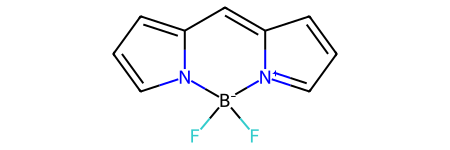

In [4]:
smile = '[B-]1(n2cccc2C=C3[N+]1=CC=C3)(F)F' # BODIPY or 4,4-difluoro-4-bora-3a,4a-diaza-s-indacene
smi_key = 'BODIPY'
# Defines a molecule from its SMILES string
mol_rdkit = Chem.MolFromSmiles(smile)
mol_rdkit

#### 3D non optimisée

In [5]:
 # Verify if the "data2402_{smi_key}" subdirectory exist and if not, create it
working_dir = Path(f'./data2403/{smi_key}')
# Create the output directory if it doesn't exist
working_dir.mkdir(parents=True, exist_ok=True)


In [6]:
try:
  import py3Dmol
except:
  !pip install py3Dmol
  import py3Dmol

In [7]:
def view3D(mol, label, fmt='mol'):
        """3D vizualisation of mol/xyz file with Py3DMol
        """

        view = py3Dmol.view(width=400, height=400)

        if fmt=='mol':
            view.addModel(Chem.MolToMolBlock(mol), fmt)
            # view.addModel(mol, fmt)
        elif fmt=='xyz':
            view.addModel(mol, fmt)

        view.setStyle({'stick': {}, 'sphere': {'scale': .30}})
        view.addLabel(label, {'position': {'x': -2, 'y': -3, 'z': 0}})

        view.zoomTo()
        view.show()

In [8]:
# Add explicit Hs
mol_rdkit = Chem.AddHs(mol_rdkit)

# Generates the initial 3D conformation of the molecule
AllChem.EmbedMolecule(mol_rdkit)

# 3D visualization
mol_rdkit0 = mol_rdkit
# path_3d_smi = working_dir / f'{smi_key}_3d_smi.png'
view3D(mol_rdkit0, f'{smi_key} RDKit Molecule')


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

#### 3D pré-optimisée avec MMFF94

In [9]:
# Optimizes the 3D conformation of the molecule using MMFF - Merck Molecular Force Field
AllChem.MMFFOptimizeMolecule(mol_rdkit, maxIters=200, mmffVariant="MMFF94s")

#Canonicalize the orientation of the conformation
Chem.rdMolTransforms.CanonicalizeMol(mol_rdkit, normalizeCovar=True, ignoreHs=False)

# 3D visualization
# path_3d_rdkit = working_dir / f'{smi_key}_3d_rdkit.png'
mol_rdkit1 = mol_rdkit
view3D(mol_rdkit1, f'{smi_key} RDKit Molecule MMFF94')


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

#### 3D à nouveau optimisée avec xTB et CREST

##### Installation et configuration de xTB et CREST

* Entrer dans le terminal (dans l'environnment python où on souhaite faire l'installation)

> `mamba install xtb, crest`
<!-- et 
> `whereis xtb`
pour obtenir le chemin des fichiers exécutables. On obtient un output semblable à ceci:
> 

* Ajouter le chemin dans `~/.bashrc`. Pour celà, il faut entrer dans 
 export XTBPATH=/home/taamangtchu/mambaforge/envs/qiskit-env/bin/xtb
 
 export PATH=$PATH:/home/taamangtchu/mambaforge/envs/qiskit-env/bin/xtb -->


In [12]:
try:
  import xtb, crest
except:
  !mamba install xtb crest # utiliser conda à la place mamba au cas où...
  import xtb, crest

##### Processus d'optimisation semi-empirique

In [14]:
import subprocess as sp # pour exécuter les processus externes (ici xtb et crest)

# Setting various paths for xtb files
path_xtb_xyz = working_dir / f'{smi_key}_opt.xyz'
path_xtb_log = working_dir / f'{smi_key}_opt.log'
path_xtb_csv = working_dir / f'{smi_key}_xtb.csv'


In [133]:
if not path_xtb_xyz.exists():
    print(f'path_xtb_xyz does not exist and will be created')

    # Convert RDKit molecule to XYZ format
    mol_rdkit_xyz = Chem.MolToXYZBlock(mol_rdkit)
    with open("mol_rdkit.xyz", "w") as f:
        f.write(mol_rdkit_xyz)

    # Geometry pre-optimization using GFn-XTB with different parameters
    sp.run(["xtb","mol_rdkit.xyz", "--gfn 2 --opt vtight", "--parallel 4"], 
            stdout=sp.PIPE, stderr=sp.PIPE, text=True, universal_newlines=True)

    # Best conformation search
    sp.run(['crest', 'xtbopt.xyz', '-gff -mquick --noreftopo'], stdout=sp.DEVNULL, stderr=sp.DEVNULL)

    # xtb geometry optimization of the crest best conformation
    xtb_process = sp.run(["xtb", 'crest_best.xyz', "--gfn 2 --opt vtight", "--parallel 4"],
                        stdout=sp.PIPE, stderr=sp.PIPE, text=True, universal_newlines=True)

    # Store the xtbopt.xyz file in path_xtb_xyz
    sp.run(['cp', 'xtbopt.xyz', path_xtb_xyz], stdout=sp.PIPE, stderr=sp.DEVNULL)

    with open(path_xtb_log, "w") as fl:
        fl.write(xtb_process.stdout)


In [134]:
# Check the output of xTB_process
print(path_xtb_log.read_text())

      -----------------------------------------------------------      
     |                   =====================                   |     
     |                           x T B                           |     
     |                   =====================                   |     
     |                         S. Grimme                         |     
     |          Mulliken Center for Theoretical Chemistry        |     
     |                    University of Bonn                     |     
      -----------------------------------------------------------      

   * xtb version 6.6.1 (8d0f1dd) compiled by 'conda@1efc2f54142f' on 2023-08-01

   xtb is free software: you can redistribute it and/or modify it under
   the terms of the GNU Lesser General Public License as published by
   the Free Software Foundation, either version 3 of the License, or
   (at your option) any later version.
   
   xtb is distributed in the hope that it will be useful,
   but WITHOUT ANY WARRANTY; w

In [ ]:
#@TODO Energy relaxation (kcal/mol) per Iteration

In [ ]:
# from matplotlib import pyplot as plt

# au2kcalmol =  627.503


# e_min_in_au = min(opt_results["opt_energies"])

# energies_in_kcalpermol = [
#     (e - e_min_in_au) * au2kcalmol for e in opt_results["opt_energies"]
# ]

# fig, ax = plt.subplots(figsize=(6, 3))

# ax.plot(energies_in_kcalpermol, "o--")

# ax.set_xlabel("Iteration")
# ax.set_ylabel(r"Energy relaxation (kcal/mol)")

# plt.show()

##### Gap HOMO-LUMO et énergie totale

Nous allons rechercher les valeurs du gap HOMO-LUMO et de l'énergie totale dans le fichier de sortie (path_xtb_log).

In [39]:
#---------------------------------------------------------------------
# Extract the total energy and Homo-lumo gap from the xtb output file
#---------------------------------------------------------------------
# Find TOTAL ENERGY value
tot_energy_line = [li for li in path_xtb_log.read_text().splitlines() if 'TOTAL ENERGY' in li]
tot_energy_line = tot_energy_line[0].split()
tot_energy_xtb = float(tot_energy_line[3])

# Find HOMO-LUMO GAP value
HL_gap_line = [li for li in path_xtb_log.read_text().splitlines() if 'HOMO-LUMO GAP' in li]
HL_gap_line = HL_gap_line[0].split()
HL_gap_xtb = float(HL_gap_line[3])

# Find HOMO index
Homo_idx_line = [li for li in path_xtb_log.read_text().splitlines() if '(HOMO)' in li]
Homo_idx_line = Homo_idx_line[0].split()
Homo_idx_xtb = int(Homo_idx_line[0])

# Find LUMO index
Lumo_idx_line = [li for li in path_xtb_log.read_text().splitlines() if '(LUMO)' in li]
Lumo_idx_line = Lumo_idx_line[0].split()
Lumo_idx_xtb = int(Lumo_idx_line[0])

In [40]:
import pandas as pd

# Create the xtb results dataframe
df_xtb = pd.DataFrame({'xtb calc':[HL_gap_xtb, tot_energy_xtb, Homo_idx_xtb, Lumo_idx_xtb]}, 
index=["HOMO-LUMO GAP (eV)","TOTAL ENERGY (a.u.)", "HOMO Index", "LUMO Index"])

# Save the xtb results dataframe to a file
with open(path_xtb_csv, "w") as f:
    f.write(f"\n\nxtb calculations of {smi_key}  \n")
    df_xtb.to_csv(f)
    
df_xtb

,xtb calc
HOMO-LUMO GAP (eV),1.790731
TOTAL ENERGY (a.u.),-39.530635
HOMO Index,35.000000
LUMO Index,36.000000


In [139]:
sp.run(['rm', 'bondlengths', 'charges', 'coord', 'coord.original', 'cregen_0.tmp', 'cregen_1.tmp', 
        'cre_members', 'crest_best.xyz', 'crest_conformers.xyz', 'crest.energies', 'crest_rotamers.xyz', 
        'gfnff_charges', 'gfnff_topo', '.history.xyz', 'struc.xyz', 'wbo','xtbopt.xyz', 'xtbopt.log', '.xtboptok', 
        'xtbrestart', 'xtbtopo.mol', 'xtblast.xyz', 'gfnff_adjacency'], stdout=sp.DEVNULL, stderr=sp.DEVNULL)

CompletedProcess(args=['rm', 'bondlengths', 'charges', 'coord', 'coord.original', 'cregen_0.tmp', 'cregen_1.tmp', 'cre_members', 'crest_best.xyz', 'crest_conformers.xyz', 'crest.energies', 'crest_rotamers.xyz', 'gfnff_charges', 'gfnff_topo', '.history.xyz', 'struc.xyz', 'wbo', 'xtbopt.xyz', 'xtbopt.log', '.xtboptok', 'xtbrestart', 'xtbtopo.mol', 'xtblast.xyz', 'gfnff_adjacency'], returncode=1)

In [140]:
# Read the XYZ file
mol_xtb_xyz = path_xtb_xyz.read_text()
lines =mol_xtb_xyz.strip().split('\n')
mol_xtb_xyz = '\n'.join(lines[:1] + [''] + lines[2:])

view3D(mol_xtb_xyz, f'{smi_key} xTB Molecule', fmt='xyz')


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [141]:
# Create the viewer object
viewer = py3Dmol.view(viewergrid=(1, 3), width=300*3, height=250, linked=True)

# Add the molecules to the viewer
viewer.addModel(Chem.MolToMolBlock(mol_rdkit0), 'mol', viewer=(0, 0))
viewer.addModel(Chem.MolToMolBlock(mol_rdkit1), 'mol', viewer=(0, 1))
viewer.addModel(mol_xtb_xyz, "xyz", viewer=(0, 2))

# Set the view style
viewer.setStyle({"stick": {}, "sphere": {"scale": 0.25}})
viewer.setViewStyle({"style": "outline", "width": 0.05})

# Add legends for each molecule
viewer.addLabel('RDKit Molecule', {'position': {'x': -2, 'y': -3, 'z': 0}}, viewer=(0, 0))
viewer.addLabel('RDKit Molecule MMFF94', {'position': {'x': -4, 'y': -3, 'z': 0}}, viewer=(0, 1))
viewer.addLabel('xTB Molecule', {'position': {'x': -2, 'y': -3, 'z': 0}}, viewer=(0, 2))

# Adjust the zoom level
viewer.zoomTo()

# Display the viewer
viewer.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Calcul du champ moyen HF

A l'issue de ce calcul, nous avons l'énergie de référence SCF. 

#### Choix de l'ensemble de base 

Nous allons d'abord effectuer le choix de l'ensemble de base nous donnant le meilleur compromis précision de la valeur de l'énergie et temps de calculs.

In [142]:
import time, datetime
# #mpi4psycf is a plugin for pyscf which enable (Message Passing Interface) parallelism
# try:
#   from mpi4pyscf import gto, scf 
# except:
#   !pip install mpi4pyscf
#   from mpi4pyscf import gto, scf 

from pyscf import gto, scf 


In [143]:

# Convert mol_rdkit object to Pyscf Mol objects
mol_xyz = '\n'.join(mol_xtb_xyz.strip().split('\n')[2:])

mol_pyscf = gto.Mole(
    atom=mol_xyz,
    charge=0,
    spin = 0,
    symmetry = True,
    unit = 'Angstrom')

In [144]:
# basis_sets = [
#     "6-31G",            # Double zeta with 6 Gaussian primitives
#     "6-31G*",           # Double zeta with 6 Gaussian primitives
#     "6-31G(d,p)",       # Double zeta with 6 Gaussian primitives with polarization functions and diffuse functions
#     "6-311G(d,p)",      # Triple zeta with polarization functions
#     "def2-SVP",         # Double zeta with polarization functions
#     "def2-SVPD",        # Double zeta with polarization functions and diffuse functions
#     "def2-TZVP",        # Triple zeta with polarization functions
#     "def2-TZVPD",       # Triple zeta with polarization functions and diffuse functions
#     "def2-TZVPP"        # Triple zeta with polarization functions and diffuse functions
# ]

In [145]:
# # To write output results of mf.analysis on a file
# # path_HF_basis_log = working_dir / f'{smi_key}_HF_basis.log'
# # mol_pyscf.output = path_HF_basis_log

# mf_energies = list()
# mf_times = list()
# nb_prim = list()

# # Perform a Mean-Field calculation for each basis set
# for bs in basis_sets:

#     # Measure execution time
#     start = time.time()
#     mol_pyscf.basis = bs
#     mol_pyscf.build()

#     mf = scf.RHF(mol_pyscf) # Create a PySCF HF mean-field object
#     mf.x2c().density_fit() # To speed up calculations
#     mf.kernel()
#     end = time.time()

#     nb_prim.append(mol_pyscf.npgto_nr())
#     mf_energies.append(mf.e_tot)
#     mf_times.append(end-start)

In [146]:
# # Create the results dataframe

# df_HF = pd.DataFrame({"Basis":basis_sets, 
#                       'Nb of GTO primitives':nb_prim, 
#                       'Total energy (a.u.)':mf_energies,
#                       "Time (s)":mf_times})

# df_HF


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Basis</th>
      <th>Nb of GTO primitives</th>
      <th>Total energy</th>
      <th>Time</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>6-31G</td>
      <td>336</td>
      <td>-677.623496</td>
      <td>3.669760</td>
    </tr>
    <tr>
      <th>1</th>
      <td>6-31G*</td>
      <td>406</td>
      <td>-677.856129</td>
      <td>5.084911</td>
    </tr>
    <tr>
      <th>2</th>
      <td>6-31G(d,p)</td>
      <td>427</td>
      <td>-677.869629</td>
      <td>5.943991</td>
    </tr>
    <tr>
      <th>3</th>
      <td>6-311G(d,p)</td>
      <td>490</td>
      <td>-678.016787</td>
      <td>9.655276</td>
    </tr>
    <tr>
      <th>4</th>
      <td>def2-SVP</td>
      <td>385</td>
      <td>-677.344944</td>
      <td>5.601832</td>
    </tr>
    <tr>
      <th>5</th>
      <td>def2-SVPD</td>
      <td>496</td>
      <td>-677.368600</td>
      <td>12.596472</td>
    </tr>
    <tr>
      <th>6</th>
      <td>def2-TZVP</td>
      <td>700</td>
      <td>-678.119895</td>
      <td>37.465839</td>
    </tr>
    <tr>
      <th>7</th>
      <td>def2-TZVPD</td>
      <td>811</td>
      <td>-678.121356</td>
      <td>49.101455</td>
    </tr>
    <tr>
      <th>8</th>
      <td>def2-TZVPP</td>
      <td>756</td>
      <td>-678.122451</td>
      <td>38.197197</td>
    </tr>
  </tbody>
</table>
</div>

In [147]:
# import matplotlib.pyplot as plt

# # Create the matplotlib figure
# fig, ax = plt.subplots(figsize=(8,5))

# # Plot the energies.
# ax.set_xticks(range(len(basis_sets)), basis_sets, rotation=45)
# ax.set_xlabel("Basis set")
# ax.set_ylabel("Energy / Hartree", color="b")
# ax.scatter(range(len(basis_sets)), mf_energies, marker="o", s=50, color="b")

# # Plot the time to solution
# ax_time = ax.twinx()
# ax_time.scatter(range(len(basis_sets)), mf_times, marker="s", s=50, color="r")
# ax_time.set_ylabel("Time to solution / s", color="r", rotation=270, va="bottom")

# # Show the graph
# plt.tick_params(axis="both", direction="in")
# plt.show()

Il apparait que nous avons le choix entre 6-311(d,p) et def2-TZVP. 

In [148]:
# # Setting path for HF results
# path_results = working_dir / f'Results_{smi_key}.csv'
# path_HF_chk = working_dir / f'{smi_key}_HF.chk'
# path_HF_log = working_dir / f'{smi_key}_HF.log'

# # To write output results of mf.analysis on a file
# mol_pyscf.output = path_HF_log
# mol_pyscf.basis = "def2-TZVP"  # Triple zeta with polarization functions

# #===============================
# # MEAN FIELD SCF CALCULATIONS
# #===============================
# mf = scf.RHF(mol_pyscf) # Create a PySCF HF mean-field object
# mf.apply(scf.addons.remove_linear_dep_) # Remove linear dependency from overlap
# matrix and use the linearly independent basis in the HF calculations
# mf.x2c().density_fit()   # To speed up calculations
# mf.init_guess = '1e' # The one-electron guess, also known as the core guess
# mf.verbose = 4
# mf.direct_scf = False
# # if phase == 'sol':
# #     mf = mf.ddCOSMO() # COSMOS Solvation method
# #     mf.with_solvent.eps = 2.3741   # Toluene


# if path_HF_chk.exists():
#     path_HF_status = f'{path_HF_chk} exist'
#     start = time.time()

#     # Load the SCF results from the checkpoint file
#     mf.__dict__.update(chkfile.load(path_HF_chk, 'scf'))
#     dm = mf.make_rdm1()
#     # mf.kernel(dm)
    

#     elapsed_HF = str(datetime.timedelta(seconds = time.time() - start))
# else:
#     path_HF_status = f'{path_HF_chk} does not exist'
#     start = time.time()

#     # Save the SCF results to a checkpoint file
#     mf.chkfile = path_HF_chk
#     mf.kernel()
#     if(not mf.converged):
#         mf = mf.newton()
#         mf.kernel()

#     elapsed_HF = str(datetime.timedelta(seconds = time.time()- start))


### DFT

Les erreurs les plus critiques et donc les plus importantes dans les approximations DFT réelles sont ce qu'on appelle l'erreur d'auto-interaction (self-interaction error, SIE) et les effets de corrélation à longue portée (ong-range correlation effects) manquants qui donnent lieu à la dispersion de London. Bien que l'absence de description de la corrélation à longue portée soit une lacune fondamentale de la DFT, elle peut aujourd'hui facilement être corrigée en incluant l'une des nombreuses corrections de dispersion éprouvées disponibles telles que la D4 ou VV10. 

#### Prise en compte de la dispersion de London et optimization géométrique de S0

* Correction de dispersion de London dépendant de la charge atomique, généralement applicable, se fera avec `dftd4`.
    * Le module fournit une classe `DFTD4Dispersion` pour construire un calculateur compatible PySCF pour évaluer l'énergie et les gradients de dispersion. Le modèle de dispersion ainsi que les paramètres sont créés localement et ne font pas partie de l'état de l'instance.
    * La méthode `energy` permet d'appliquer une correction de dispersion à un calculateur existant. Sinon, `dftd4.pyscf.energy(mf)` applique les corrections DFT-D4 aux méthodes SCF en renvoyant une instance d'une nouvelle classe construite à partir de la classe d'instances d'origine.

In [149]:
try:
  import dftd4.pyscf as disp # Dispersion correction module
except:
  !mamba install dftd4 dftd4-python # utiliser conda à la place mamba au cas où...
  import dftd4.pyscf as disp # Dispersion correction module

In [150]:
mol_pyscf.build()
md4 = disp.DFTD4Dispersion(mol_pyscf, xc='B3LYP') 
md4.kernel()[0]

array(-0.04456596)

In [ ]:
md4.Hessian().kernel() # Frequences positive si bonne minimisation

#### Optimisation géométrique de S0

 L'optimisation géométrique de S0 se fera avec la bibliothèque *geomeTRIC*.

In [151]:
try:
  from pyscf.geomopt.geometric_solver import optimize
except:
  !pip install pyscf[geomopt]
  from pyscf.geomopt.geometric_solver import optimize

In [152]:
def min_TRIC_energy(logfile):
    """Read the geometry optimization logfile and extract
      the last "converged SCF energy", that is the minimum 
      energy of the state, at the end that file
    """

    with open(logfile, "r") as f:
        log_contents = f.read()

    lines = log_contents.split("\n")
    # Reverse the lines so we can start reading from the end
    for line in reversed(lines):
        if ": E =" in line:
            energy = line.split(": E =")[1].strip().split()[0]
            return float(energy)

* On rappelle que par défaut, les grilles d'intégration PySCF DFT utilisent
     * Rayon de Bragg pour l'atome (Bragg radius for atom)
     * Grilles radiales Treutler-Ahlrichs (Treutler-Ahlrichs radial grids)
     * Séparation Becke pour les poids de grille (Becke partition for grid weights)
     * Schéma d'élagage NWChem (NWChem pruning scheme)
     * grilles maillées (mesh grids)

In [153]:
import numpy as np

from pyscf.data import nist 
from pyscf import dft, tddft
# from mpi4pyscf import dft, tddft
from pyscf.lib import chkfile
from pyscf.tools import cubegen, molden

au2ev = nist.HARTREE2EV

In [154]:
# Setting path for DFT results, chkfile and analyze object
path_results = working_dir / f'Results_{smi_key}.csv'
path_DFT_chk = working_dir / f'{smi_key}_DFT.chk'
path_DFT_log = working_dir / f'{smi_key}_DFT.log'
path_DFT_xyz = working_dir / f'{smi_key}_DFT.xyz'

# write output results of mdft.analysis on a file
mol_pyscf.output = path_DFT_log
mol_pyscf.verbose = 5

mol_pyscf.basis =  "def2-TZVP"
mol_pyscf.build()


overwrite output file: data2403/BODIPY/BODIPY_DFT.log


In [155]:
# Function to perform DFT calculations with or without dispersion
def perform_dft_calculation(mol, dispersion = True):

    mdft = dft.RKS(mol) # Create a PySCF DFT mean-field object
    mdft.density_fit(auxbasis='def2-universal-jkfit') # To speed up calculations
    mdft.xc = 'B3LYP'
    mdft.nlc = 'VV10' # To specify the inclusion of the VV10 nonlocal correlation functional
    mdft.max_cycle = 512
    mdft.grids.level = 4  # Level of grid accuracy (higher is more accurate)
    mdft.conv_tol = 1E-7
    mdft.grids.becke_scheme = dft.gen_grid.original_becke # Use the Becke 'Good' grid
    mdft._numint.libxc = dft.xcfun # Switch to xcfun because 3rd order GGA functional derivative is not available in libxc
    mdft.verbose = 5
    mdft.init_guess = 'huckel' # Basically a tight-binding guess (see J. Chem. Theory Comput. 15, 1593 (2019))
    
    if dispersion:
        if path_DFT_chk.exists():
            print(f'{path_DFT_chk} exist')
            # Load the DFT results from the checkpoint file
            mdft.__dict__.update(chkfile.load(path_DFT_chk, 'scf'))
            mdft = disp.energy(mdft).run()
        else:
            # Save the DFT results to a checkpoint file
            mdft.chkfile = path_DFT_chk

            mdft = disp.energy(mdft).run()    
    
    else:
        if path_DFT_chk.exists():
            # Load the DFT results from the checkpoint file
            mdft.__dict__.update(chkfile.load(path_DFT_chk, 'scf'))
            mdft = mdft.run()
        else:
            # Save the DFT results to a checkpoint file
            mdft.chkfile = path_DFT_chk

            mdft = mdft.run()
            
    return mdft


In [156]:
# S0 Optimization
mdft = perform_dft_calculation(mol_pyscf, dispersion = 'd4')


** DFTD4 parameter **
func B3LYP


In [157]:
mol_TRIC = optimize(mdft)

geometric-optimize called with the following command line:
/home/taamangtchu/mambaforge/envs/qiskit-env/lib/python3.10/site-packages/ipykernel_launcher.py -f /home/taamangtchu/.local/share/jupyter/runtime/kernel-v2-26800jD69KpJcL2O.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%,  **

overwrite output file: data2403/BODIPY/BODIPY_DFT.log
overwrite output file: data2403/BODIPY/BODIPY_DFT.log
** DFTD4 parameter **
func B3LYP


In [70]:
e_d4 = min_TRIC_energy(path_DFT_log)
e_d4

-681.270736429

In [1]:
path_DFT_xyz = working_dir / f'{smi_key}_DFT.xyz'
mol_TRIC.tofile(path_DFT_xyz)

NameError: name 'working_dir' is not defined

In [53]:
view3D(path_DFT_xyz.read_text(), f'{smi_key} S0 DFTD4 Molecule', fmt='xyz')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
mol_xyz_d4 = open('opt_d4_disp.xyz').read()
mol_xyz_d4 = '\n'.join(mol_xyz_d4.strip().split('\n')[2:])

mf_no_disp1 = perform_dft_calculation(mol_pyscf, mol_xyz_d4, method='HF')

#### Taking into account dispersion with `dftd4`

* The module provides a `DFTD4Dispersion` class to construct a PySCF compatible calculator for evaluating the dispersion energy and gradients. The dispersion model as well as the parameters are created locally and not part of the state of the instance.

In [30]:
md4 = disp.DFTD4Dispersion(mol_pyscf, xc='B3LYP') 
md4.kernel()[0]

array(-0.04456596)

* The `energy` method allows to apply a dispersion correction to an existing calculator. Otherwise, `dftd4.pyscf.energy(mf)` apply DFT-D4 corrections to SCF methods by returning an instance of a new class built from the original instances class.

* We recall that by default, the PySCF DFT integration grids use
    * 
    * 
    * 
    * 
    * 

In [34]:


# if phase == 'sol':
# # Set up the COSMO solvation model
#     mdft = mdft.run().ddCOSMO()
#     mdft.with_solvent.eps = 2.3741   # Toluene

if path_DFT_chk.exists():
    path_DFT_status = f'{path_DFT_chk} exist'
    start = time.time()

    # Load the DFT results from the checkpoint file
    mdft.__dict__.update(chkfile.load(path_DFT_chk, 'scf'))
    # mdft.init_guess = path_DFT_chk
    # mdft.kernel()
    mdft = disp.energy(mdft).run()

    elapsed_DFT = str(datetime.timedelta(seconds = time.time() - start))
else:
    path_DFT_status = f'{path_DFT_chk} does not exist'
    start = time.time()

    # Save the DFT results to a checkpoint file
    mdft.chkfile = path_DFT_chk
    mdft = disp.energy(mdft).run()
    
    if(not mdft.converged):
        mdft = mdft.newton(mdft)
        mdft = disp.energy(mdft).run()

    elapsed_DFT = str(datetime.timedelta(seconds = time.time()- start))

# Analyze the given DFT object
mdft.analyze()



******** <class 'dftd4.pyscf.energy.<locals>.DFTD4'> ********
method = DFTD4-RKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-07
SCF conv_tol_grad = None
SCF max_cycles = 512
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /media/taamangtchu/MYDATA/Workplace/QisKit/UY1_NE_Qiskit/Quantum_Chem/tmpnkld9u_e
max_memory 4000 MB (current use 208 MB)
XC library pyscf.dft.xcfun version 2.1.1
    XCFun DFT library Copyright 2009-2020 Ulf Ekstrom and contributors.
See http://dftlibs.org/xcfun/ for more information.

This is free software; see the source code for copying conditions.
There is ABSOLUTELY NO WARRANTY; not even for MERCHANTABILITY or
FITNESS FOR A PARTICULAR PURPOSE. For details see the documentation.
Scientific users of this library should cite
U. Ekstrom, L. Visscher, R. Bast, A. J. Thorvaldsen and K. Ruud;
J.Chem.Theor.Comp. 2010, DOI: 10.1021/ct100

((array([1.99961993e+00, 6.23287044e-01, 9.52162248e-03, 3.63945259e-04,
         8.09017956e-04, 6.49987483e-01, 5.80323724e-01, 5.34336741e-01,
         8.10118181e-03, 1.45096045e-02, 2.17281958e-02, 1.43033688e-03,
         1.49053800e-03, 1.30387325e-03, 4.63372330e-03, 3.11850305e-03,
         4.93648157e-03, 4.67220504e-03, 9.01992148e-04, 4.95287868e-04,
         7.83763116e-04, 6.46608891e-04, 3.69706032e-04, 1.26368282e-03,
         2.29095997e-04, 4.06901263e-04, 7.50228454e-04, 6.11997581e-04,
         3.89810580e-05, 1.78231814e-04, 3.33566369e-04, 1.99991277e+00,
         1.20902236e+00, 2.72002404e-03, 7.17655190e-04, 4.82216365e-05,
         1.26265205e+00, 1.20487862e+00, 1.39288256e+00, 2.14246748e-03,
         2.51022133e-03, 3.98407861e-03, 5.28018357e-04, 4.57213832e-04,
         4.79121259e-04, 2.62734192e-04, 8.54952655e-04, 2.80124022e-03,
         1.04978196e-03, 1.41812998e-03, 3.99433738e-04, 1.25375249e-04,
         3.70069496e-04, 9.48392054e-05, 2.83915632

In [35]:
mol_eq = optimize(mdft)
print(mol_eq.atom_coords())

Create scanner for <class 'dftd4.pyscf.grad.<locals>.DFTD4Grad'>
Create scanner for <class 'dftd4.pyscf.energy.<locals>.DFTD4'>


geometric-optimize called with the following command line:
/home/taamangtchu/mambaforge/envs/qiskit1-env/lib/python3.10/site-packages/ipykernel_launcher.py -f /home/taamangtchu/.local/share/jupyter/runtime/kernel-v2-108331sje2LIoXf8RC.json

                                        ())))))))))))))))/                     
                                    ())))))))))))))))))))))))),                
                                *)))))))))))))))))))))))))))))))))             
                        #,    ()))))))))/                .)))))))))),          
                      #%%%%,  ())))))                        .))))))))*        
                      *%%%%%%,  ))              ..              ,))))))).      
                        *%%%%%%,         ***************/.        .)))))))     
                #%%/      (%%%%%%,    /*********************.       )))))))    
              .%%%%%%#      *%%%%%%,  *******/,     **********,      .))))))   
                .%%%%%%/      *%%%%%%, 


Geometry optimization cycle 1
Cartesian coordinates (Angstrom)
 Atom        New coordinates             dX        dY        dZ
   B   0.000080  -1.163105   0.000114    0.000000  0.000000  0.000000
   N  -1.246348  -0.241233   0.001286    0.000000  0.000000  0.000000
   C  -2.517460  -0.619705   0.002963    0.000000  0.000000 -0.000000
   C  -3.356859   0.503902   0.002395    0.000000  0.000000  0.000000
   C  -2.540668   1.611436   0.000080    0.000000  0.000000  0.000000
   C  -1.205670   1.137942  -0.000470    0.000000  0.000000  0.000000
   C  -0.000450   1.820913  -0.001708    0.000000  0.000000  0.000000
   C   1.205015   1.138369  -0.000829    0.000000  0.000000  0.000000
   N   1.246179  -0.240790   0.000868    0.000000  0.000000  0.000000
   C   2.517426  -0.618815   0.002222    0.000000  0.000000  0.000000
   C   3.356428   0.505087   0.001524   -0.000000  0.000000  0.000000
   C   2.539845   1.612335  -0.000603   -0.000000  0.000000  0.000000
   F   0.000016  -1.948276  -1.1

In [55]:
# Dipole moment
dip_mt2 = mdft.dip_moment(mdft.mol, mdft.make_rdm1())

# Index of HOMO and LUMO
homo_idx = np.where(mdft.mo_occ > 0)[0][-1]
lumo_idx = np.where(mdft.mo_occ == 0)[0][0]

# Output cube files for active orbitals that can read by Vesta or XCryDen
for i in [homo_idx, lumo_idx]:
    cubegen.orbital(
        mol_pyscf,
        working_dir / f'{smi_key}_DFTD4_{i+1}.cube',
        mdft.mo_coeff[:, i])

# Generating molecular orbitals
with open(working_dir / f'{smi_key}_DFTD$_{i+1}.molden', 'w') as f1:
    molden.header(mol, f1)
    molden.orbital_coeff(mol, f1, mf.mo_coeff, ene=mf.mo_energy, occ=mf.mo_occ)


TypeError: '>' not supported between instances of 'NoneType' and 'int'

In [ ]:
# Create the DFT results dataframe
list_results_DFT = [mdft.e_tot,
                    mdft.energy_elec()[0],
                    mdft.energy_nuc(),
                    mdft.mo_energy[homo_idx],
                    mdft.mo_energy[lumo_idx],
                    mdft.mo_energy[homo_idx] - mdft.mo_energy[lumo_idx]]
dict_results_DFT = {'a.u.': list_results_DFT,
                'eV': [x * au2ev for x in list_results_DFT]}
df_DFT = pd.DataFrame(dict_results_DFT,
                    index = ['Total energy',
                                'Electronic energy',
                                'Nuclear repulsion energy',
                                'MO energy of HOMO',
                                'MO energy of LUMO',
                                'HOMO-LUMO gap'])

# Save the DFT results dataframe to a file
with open(path_results, "a") as f:
    f.write(f"\n\nDFT calculations of {smi_key} obtained in; \
        {elapsed_DFT}s ; as {path_DFT_status} \n")
    f.write(f"Dipole moments ; {dip_mt2[0], dip_mt2[1], dip_mt2[2]}\n")

    df_DFT.to_csv(f)

### TDDFT-TDA calculations

In [ ]:
#==================================
# TDDFT-TDA CALCULATIONS
#==================================

# Setting path for TDDFT results, chkfile and analyze object
path_DFT1_log = working_dir / f'{smi_key}_DFT1.log'
path_TDDFT_S1_xyz_opt = working_dir / f'{smi_key}_TDDFT_S1.xyz'
path_TDDFT_T1_xyz_opt = working_dir / f'{smi_key}_TDDFT_T1.xyz'
path_TDDFT_S1_png = working_dir / f'{smi_key}_S1_TDDFT.png'
path_TDDFT_T1_png = working_dir / f'{smi_key}_T1_TDDFT.png'


#### S1 and T1 geometry optimizations

In [ ]:
# 



In [ ]:
# Singlets ES TDDFT calculations with Tamm-Dancoff-approximation
#==================================
mftda = tddft.TDA(mftda)
mftda.nstates = 2  # Calculate S1 and T1
# if phase == 'sol':
#     mftda = mftda.ddCOSMO()
#     mftda.with_solvent.eps = 2.3741   # Toluene
#     mftda.with_solvent.equilibrum_solvation = True

# Geometry optimizer of excited states
mol_eq = mftda.nuc_grad_method().as_scanner(state=2).optimizer().kernel()
# # Add callback to geometry optimizer
# mftda = mftda.nuc_grad_method().as_scanner(state=2).optimizer()
# mftda.callback = cb
# mftda.kernel()

# Setting path for singlets TDDFT-TDA chkfile
path_TDA_chk = working_dir / f'{smi_key}_TDA.chk'

if path_TDA_chk.exists():
    path_TDA_status = f'{path_TDA_chk} exist'
    start = time.time()

    # Load the TDA singlet results from the checkpoint file
    mftda.__dict__.update(chkfile.load(path_TDA_chk, 'tddft'))
    E_TDA = mftda.kernel()

    elapsed_TDA = str(datetime.timedelta(
        seconds = time.time() - start))
else:
    path_TDA_status = f'{path_TDA_chk} does not exist'
    start = time.time()

    # Save the TDA singlet results to a checkpoint file
    mftda.chkfile = path_TDA_chk
    E_TDA = mftda.kernel()
    #if(not mftda.converged):
        #mftda = tddft.TDA.newton(mftda)
        #E_TDA = mftda.kernel()

    elapsed_TDA = str(datetime.timedelta(
        seconds = time.time()- start))

# Singlet excitation energies
ee_singlets = mftda.e

# Singlet oscillators strength
OS_singlets = mftda.oscillator_strength(gauge='length')


# Triplets ES TDDFT calculations with Tamm-Dancoff-approximation
#==================================
mftda.singlet = False

# Setting path for triplets TDDFT-TDA chkfile
path_TDA3_chk = working_dir / f'{smi_key}_TDA3.chk'

if path_TDA3_chk.exists():
    path_TDA3_status = f'{path_TDA3_chk} exist'
    start = time.time()

    # Load the TDA triplet results from the checkpoint file
    mftda.__dict__.update(chkfile.load(path_TDA3_chk, 'tddft'))
    E_TDA3 = mftda.kernel()

    elapsed_TDA3 = str(datetime.timedelta(seconds = time.time() - start))
else:
    path_TDA3_status = f'{path_TDA3_chk} don\'t exist'
    start = time.time()

    # Save the TDA results to a checkpoint file
    mftda.chkfile = path_TDA3_chk
    E_TDA3 = mftda.kernel()

    elapsed_TDA3 = str(datetime.timedelta(seconds = time.time() - start))

# Triplet excitation energies
ee_triplets = mftda.e


NameError: name 'mftda' is not defined

In [ ]:
# Sought results
#==================================
#
# fluorescence energy
f_energy = min(ee_singlets)

# Singlet-Tiplet gap
gap_ST = min(ee_singlets) - min(ee_triplets)

# Oscillator strength
OStr = OS_singlets[0]

# Lifetime calculation in au
c = nist.LIGHT_SPEED # in au
time_au = 2.4188843265857E-17 # in au

tau_au = c**3 / (2 * (f_energy)**2 * OStr)
tau = tau_au * time_au

# Multi-Objective function
mobj = OStr - gap_ST * au2ev - np.abs(f_energy * au2ev - 3.2)

#=====================================
# DataFrame and saving in file
#=====================================

# Create the results dataframe
list_results_TDA = [f_energy, gap_ST, OStr, tau, mobj]
dict_results_TDA = {'a.u.': list_results_TDA,
            'eV/ns': [f_energy * au2ev,
                    gap_ST * au2ev,
                    OStr,
                    tau * 1E+9,
                    mobj]}

df_TDA = pd.DataFrame(dict_results_TDA,
                    index = ['Fluorescence energy',
                                'Singlet-Triplet gap',
                                'Oscillator strength',
                                'Lifetime',
                                'Multi-Obj'])

# Save the TDDFT-TDA results dataframe to a file
with open(path_results, "a") as f:
    f.write(f"\n\nTDDFT-TDA calculations of {smi_key} obtained in; \
            {elapsed_TDA}s ; as {path_TDA_status}\n \
            {elapsed_TDA3}s ; as {path_TDA3_status}\n")
    df_TDA.to_csv(f)
